ds-project-data-engineering-group4

Jean Philippe Petit-Frère
Lesley Borowski
Mike Sorensen
Sandeep Butukuri


In [1]:
import re
import requests
import pandas as pd
from pandas import json_normalize
import numpy as np
import json
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords

In [2]:
# Initialize dataframe
show_df = pd.DataFrame(columns = ['show_id', 'name', 'genre', 'summary', 'airdate', 'country'])
show_df

,show_id,name,genre,summary,airdate,country


In [3]:
# Create count dict and initialize a date list and data container
country_dict = {'USA':'US', 'Canada':'CA', 'UK':'GB', 'Australia':'AU'}
date_range = []
scrape_data = []

# Pass 7 day range from specified years into date list
for year in range (2021, 2006, -1):
    for day in range(1,8):
        date = f'{year}-09-0{day}'
        date_range.append(date)

# Scrape tv show data from 'https://www.tvmaze.com/api'
for country, code in country_dict.items():
    for date in date_range:
        
        r = requests.get(f'https://api.tvmaze.com/schedule?country={code}&date={date}')
        content = json.loads(r.content)
        c = content
                
        for i in range(len(c)):
            if c[i]['show']['genres'] == []:
                continue
            show_data = pd.DataFrame({'show_id':[c[i]['show']['id']], 'name':[c[i]['show']['name']], 
                                      'all_genres':[c[i]['show']['genres']], 'summary':[c[i]['show']['summary']], 
                                      'airdate':date, 'country':country})
            scrape_data.append(show_data)

In [4]:
# Compile tv show dataframe
show_df = pd.concat([*scrape_data, show_df], ignore_index=True)
# Remove duplicate shows by Show_ID
show_df = show_df.drop_duplicates(subset=['show_id'], keep='first')

# Make new genre column for primary genre
show_df['genre'] = show_df.apply(lambda row: row['all_genres'][0],axis=1)
# Convert all_genres to string for processing
show_df['genre_string'] = [','.join(map(str, l)) for l in show_df['all_genres']]

print(show_df.shape)
show_df.head(3)

(2298, 8)


,show_id,name,all_genres,summary,airdate,country,genre,genre_string
0,2831,The Late Late Show with James Corden,"[Comedy, Music]","<p>Each week night, <b>The Late Late Show with...",2021-09-01,USA,Comedy,"Comedy,Music"
1,17546,Poker After Dark,[Sports],"<p>On <b>Poker After Dark</b>, professional po...",2021-09-01,USA,Sports,Sports
2,44660,The Bump,[Sports],<p>WWE's <b>The Bump</b> is unlike any WWE sho...,2021-09-01,USA,Sports,Sports


In [5]:
# Review unique genres for clustering
show_df.genre.unique()

array(['Comedy', 'Sports', 'Drama', 'Family', 'Adult', 'Action', 'Food',
       'Music', 'Mystery', 'Romance', 'Medical', 'Adventure', 'DIY',
       'History', 'Crime', 'Horror', 'Children', 'Nature', 'Supernatural',
       'Travel', 'Legal', 'Thriller', 'Science-Fiction', 'Fantasy',
       'Anime', 'War'], dtype=object)

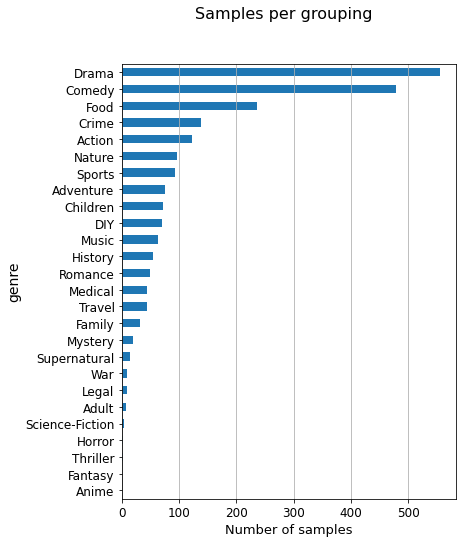

In [6]:
import matplotlib.pyplot as plt
# Visualize group sizes
fig, ax = plt.subplots(figsize=(6,8))
fig.suptitle('Samples per grouping', fontsize=16)
plt.xlabel('Number of samples', fontsize=13)
plt.ylabel('Genre', fontsize=14)
show_df['genre'].reset_index().groupby('genre').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax, fontsize=12).grid(axis='x')
plt.show()

In [7]:
# Find genres that are most commonly grouped together
genre_groups = show_df.groupby('genre_string').count()
genre_groups = genre_groups.sort_values(by='all_genres', ascending=False)

genre_groups['all_genres'].head(20)

genre_string
Comedy                     293
Food                       178
Crime                      116
Sports                      94
Drama                       80
Nature                      72
DIY                         70
Drama,Crime                 59
Music                       59
Children                    56
History                     51
Action,Adventure,Nature     49
Romance                     47
Food,Travel                 46
Medical                     43
Drama,Comedy                36
Drama,Romance               36
Travel                      34
Comedy,Family               31
Drama,Crime,Thriller        28
Name: all_genres, dtype: int64

In [8]:
# Drop redundant columns
show_df = show_df.drop(['all_genres','genre_string'], axis=1)

# Re-map genres according to most common co-occurrences
# This helped to account for less frequently occurring genres, which could negatively affect clustering
show_df['genre'] = show_df['genre'].map({'Medical':'Drama', 'Crime':'Drama', 'Drama':'Drama', 'Romance':'Drama',
                                         'Children':'Children', 'Comedy':'Comedy', 'Family':'Comedy', 'Action':'Action', 
                                         'Adventure':'Action', 'Nature':'Action', 'DIY':'DIY', 'Sports':'Sports',
                                         'Food':'Lifestyle', 'Travel':'Lifestyle', 'Adult':'Other', 'Music':'Music',
                                         'Horror':'Other', 'Supernatural':'Other', 'History':'Other', 'War':'Other', 
                                         'Thriller':'Other', 'Legal':'Other', 'Mystery':'Other', 'Science-Fiction':'Other',
                                        'Fantasy':'Other', 'Anime':'Other'})
print(show_df.shape)
show_df.head(3)

(2298, 6)


,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,"<p>Each week night, <b>The Late Late Show with...",2021-09-01,USA,Comedy
1,17546,Poker After Dark,"<p>On <b>Poker After Dark</b>, professional po...",2021-09-01,USA,Sports
2,44660,The Bump,<p>WWE's <b>The Bump</b> is unlike any WWE sho...,2021-09-01,USA,Sports


In [9]:
# Check for missed categories as 'nan'
show_df.genre.unique()

array(['Comedy', 'Sports', 'Drama', 'Other', 'Action', 'Lifestyle',
       'Music', 'DIY', 'Children'], dtype=object)

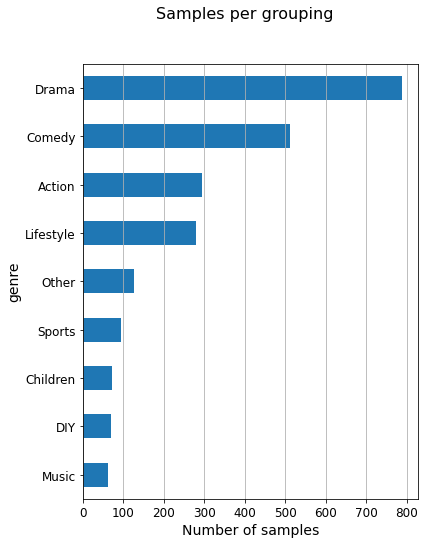

In [10]:
import matplotlib.pyplot as plt
# Visualize group sizes
fig, ax = plt.subplots(figsize=(6,8))
fig.suptitle('Samples per grouping', fontsize=16)
plt.xlabel('Number of samples', fontsize=14)
plt.ylabel('Genre', fontsize=14)
show_df['genre'].reset_index().groupby('genre').count().sort_values(by=
       "index").plot(kind="barh", legend=False, 
        ax=ax, fontsize=12).grid(axis='x')
plt.show()

In [11]:
# Text pre-processing
# Convert Summary data to type(str)
show_df['summary'] = show_df['summary'].apply(lambda x: str(x))
# Remove html tags and leading 'b's
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'<.*?>').sub(r' ',row))
# Remove special characters, replace with space
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\W').sub(r' ',row))
# Remove single characters
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\s+[a-zA-Z]\s+').sub(r' ',row))
# Remove non-letter characters from start
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\^[a-zA-Z]\s+').sub(r' ',row))
# Remove numbers from summaries
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'[0-9]').sub(r' ',row))
# Clean up multi-space gaps
show_df['summary'] = show_df['summary'].apply(lambda row: re.compile(r'\s+').sub(r' ',row))
# Converting to lower case
show_df['summary'] = show_df['summary'].apply(lambda row: row.lower())

show_df

,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,each week night the late late show with james...,2021-09-01,USA,Comedy
1,17546,Poker After Dark,on poker after dark professional poker player...,2021-09-01,USA,Sports
2,44660,The Bump,wwe the bump is unlike any wwe show you ve ev...,2021-09-01,USA,Sports
3,4344,The Young and the Restless,the young and the restless revolves around th...,2021-09-01,USA,Drama
4,812,Days of Our Lives,days of our lives is set in the fictitious mi...,2021-09-01,USA,Drama
...,...,...,...,...,...,...
6326,27372,RSPCA Animal Rescue,hosted by blue wiggle anthony field rspca ani...,2007-09-04,Australia,Action
6329,1374,McLeod's Daughters,the four female leads carry the heart of each...,2007-09-05,Australia,Drama
6330,7295,Thank God You're Here,each episode involves four celebrities walkin...,2007-09-05,Australia,Comedy
6332,1285,Summer Heights High,over one term documentary crew films the ever...,2007-09-05,Australia,Drama


In [12]:
# Stopword function
import nltk
from nltk.corpus import stopwords

def stopword(string):
    res = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(res)

# Apply stopwords function to summaries
show_df['summary'] = show_df['summary'].apply(lambda text: stopword(text))
show_df.head()

,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,week night late late show james corden throws ...,2021-09-01,USA,Comedy
1,17546,Poker After Dark,poker dark professional poker players phil hel...,2021-09-01,USA,Sports
2,44660,The Bump,wwe bump unlike wwe show ever seen featuring d...,2021-09-01,USA,Sports
3,4344,The Young and the Restless,young restless revolves around rivalries roman...,2021-09-01,USA,Drama
4,812,Days of Our Lives,days lives set fictitious midwestern town sale...,2021-09-01,USA,Drama


In [13]:
# Initialize lemmatizer
from nltk.stem import WordNetLemmatizer

wl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
# Download and import tokenizer libraries

# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

# Tokenize Summaries
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    res = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(res)

# Apply lemmatizer function to summaries
show_df['summary'] = show_df['summary'].apply(lambda text: lemmatizer(text))
show_df.head()

,show_id,name,summary,airdate,country,genre
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports
3,4344,The Young and the Restless,young restless revolve around rivalry romance ...,2021-09-01,USA,Drama
4,812,Days of Our Lives,day live set fictitious midwestern town salem ...,2021-09-01,USA,Drama


In [15]:
# Initialize tokenizer and tokenize summary data
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

show_df['tokens'] = show_df['summary'].apply(tokenizer.tokenize)
print(show_df.shape)
show_df.head()

(2298, 7)


,show_id,name,summary,airdate,country,genre,tokens
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy,"[week, night, late, late, show, jam, corden, t..."
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports,"[poker, dark, professional, poker, player, phi..."
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports,"[wwe, bump, unlike, wwe, show, ever, see, feat..."
3,4344,The Young and the Restless,young restless revolve around rivalry romance ...,2021-09-01,USA,Drama,"[young, restless, revolve, around, rivalry, ro..."
4,812,Days of Our Lives,day live set fictitious midwestern town salem ...,2021-09-01,USA,Drama,"[day, live, set, fictitious, midwestern, town,..."


In [16]:
# Create token length count column
show_df['token_count'] = [len(x) for x in show_df['tokens']]

In [17]:
# Calculate total word count and number of unique words

# !pip install keras
# !pip install tensorflow
import tensorflow
import keras
from keras.preprocessing.text import Tokenizer

all_words = [word for tokens in show_df['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in show_df['tokens']]
VOCAB = sorted(list(set(all_words)))
print(f'{len(all_words)} words total')
print(f'{len(VOCAB)} words in vocabulary')

92239 words total
13205 words in vocabulary


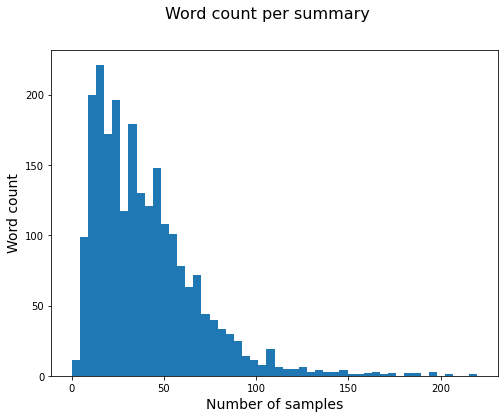

In [18]:
# Check for outlier data with histplot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('Word count per summary', fontsize=16)
plt.xlabel('Number of samples', fontsize=14)
plt.ylabel('Word count', fontsize=14)
plt.hist(sentence_lengths, bins=50);

In [19]:
# Drop outliers
show_df = show_df.drop(show_df[show_df.token_count <= 15].index)
show_df = show_df.drop(show_df[show_df.token_count > 100].index)
print(show_df.shape)
show_df.head()

(1801, 8)


,show_id,name,summary,airdate,country,genre,tokens,token_count
0,2831,The Late Late Show with James Corden,week night late late show jam corden throw ult...,2021-09-01,USA,Comedy,"[week, night, late, late, show, jam, corden, t...",65
1,17546,Poker After Dark,poker dark professional poker player phil hell...,2021-09-01,USA,Sports,"[poker, dark, professional, poker, player, phi...",29
2,44660,The Bump,wwe bump unlike wwe show ever see feature dyna...,2021-09-01,USA,Sports,"[wwe, bump, unlike, wwe, show, ever, see, feat...",22
3,4344,The Young and the Restless,young restless revolve around rivalry romance ...,2021-09-01,USA,Drama,"[young, restless, revolve, around, rivalry, ro...",44
4,812,Days of Our Lives,day live set fictitious midwestern town salem ...,2021-09-01,USA,Drama,"[day, live, set, fictitious, midwestern, town,...",22


We attempted to build a dictionary with only statistically significant words to see if clustering using only these values would result in more accurate predictions. Ultimately this did not work and we abandoned it.

In [24]:
# # Building a new dictionary with only statistically significant words
# from sklearn import feature_extraction
# from sklearn import feature_selection
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = feature_extraction.text.TfidfVectorizer(max_features=len(VOCAB), ngram_range=(1,2))

# X = show_df['summary']
# y = show_df['genre']
# vectorizer.fit(X)

# X = vectorizer.transform(X)
# dict_vocabulary = vectorizer.vocabulary_

# X_names = vectorizer.get_feature_names()
# p_value_limit = 0.95

# # Initialize features df
# show_df_features = pd.DataFrame()
# # Keep only the feature that are statistically significant in predicting genre
# for category in np.unique(y):
#     chi2, p = feature_selection.chi2(X, y == category)
#     show_df_features = show_df_features.append(pd.DataFrame({'feature':X_names, 'score':1-p, 'y':category}))
#     show_df_features = show_df_features[show_df_features['score'] > p_value_limit]
    
# X_names = show_df_features['feature'].unique().tolist()

In [310]:
# print(show_df_features.shape)
# show_df_features.head()

In [25]:
# Top 10 statistically significant words per category
# for category in np.unique(y):
#     print(f'* {category}:')
#     print('  - Statistically significant features:', 
#          len(show_df_features[show_df_features['y'] == category]))
#     print("  -", ", ".join(show_df_features[show_df_features['y'] == category]['feature'].values[:10]),'\n')

* Action:
  - Statistically significant features: 59
  - across north, adventure, adventurer, africa, alaska, alaskan, animal, animal remarkable, big game, bot 

* Children:
  - Statistically significant features: 196
  - across canada, adventure, age across, air nickelodeon, alien come, american child, animate, animated, animated character, animated series 

* Comedy:
  - Statistically significant features: 27
  - animation, celebrity, clip, comedian, comedic, comedy, comedy series, comic, dad, fake 

* DIY:
  - Statistically significant features: 302
  - alternative require, amaze new, amy matthew, anna richardson, architectural, attic, automotive, bad home, bad renovation, bath 

* Drama:
  - Statistically significant features: 31
  - case, chef, cook, cop, crime, criminal, detective, doctor, dr, drama 

* Lifestyle:
  - Statistically significant features: 135
  - aarón, across america, adam richman, ainsley, alton, amateur, anthony, bake, barbecue, bbq 

* Music:
  - Statistically 

Text(0.5, 1.0, 'Elbow method')

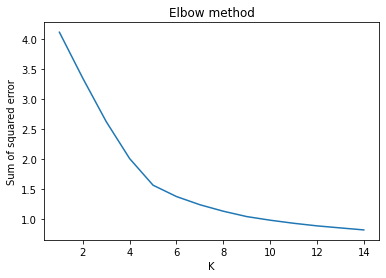

In [73]:
import statsmodels.api as sm
import scipy as sc
import sklearn.feature_extraction.text as text
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import r2_score,fowlkes_mallows_score

# Keep only the 10,000 highest occurring words that do not appear in more than 70% of samples
tf = text.TfidfVectorizer(max_features=10000, max_df=0.7)#, vocabulary=X_names) # did not end up using custom dictionary
# Convert df using TF-IDF features
X = tf.fit_transform(show_df['summary'])
y = show_df['genre']
# Initialize PCA with 500 components and fit X
pca = PCA(n_components=5)
X = pca.fit(X.todense().T).components_.T

# Calculate KMeans n_clusters with elbow method
sse = []
k_rng = range(1,15)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

#plotting the 'elbow' graph
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)
plt.title('Elbow method')

The elbow graph indicates that 5-6 clusters would be optimal, but we chose to use n_cluster=9 because our goal was to fit the data into the nine target genres

In [78]:
# Create 9 clusters from data 
km = KMeans(n_clusters=9)
km.fit(X)

# Create predictions
y_pred = km.predict(X)
# Retrieve Fowlkes Mallows score
fowlkes_mallows_score(y, y_pred)

0.27368200393223574

Our Fowlkes Mallow result indicates there is a ~30% overlap between the predicted results and actual labels

In [75]:
from sklearn.metrics import homogeneity_completeness_v_measure

# Retrieve Homogeneity Completeness score
homogeneity_completeness_v_measure(y, y_pred)

(0.28286403850642666, 0.254458488197462, 0.2679104337772895)

Homogeneity and completeness are measured with a score between 1 and 0, with one being more desirable. Our model would achieve homogeneity if each of our clusters only contained data points from 1 individual genre, similarly it would achieve completeness if all members of a genre were within the same cluster for all clusters. The v-measure provides an average of the 2. We can see from our results that our clusters are neither homogenous nor complete.

In [76]:
# Number of predictions per category
show_df['y_pred'] = y_pred
df1 = show_df.groupby(y_pred).count()
df1[['y_pred']]

,y_pred
0,492
1,216
2,138
3,101
4,73
5,287
6,122
7,313
8,59


We first plotted our predictions on a 2d plot, but the results weren't easily interpretable so we instead opted to use a 3d scatterplot

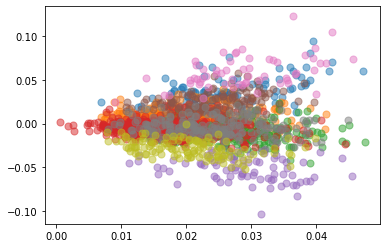

In [79]:
def get_plots(cluster_number):
    for i in range(cluster_number):
        plt.scatter(X[y_pred == i,0],X[y_pred == i,1], s=50, alpha=.5)
    plt.show()
    
get_plots(9)

We created a new dataframe with the x,y,z coordinates of our datapoints to more easily make use of Plotly's visualization tools

In [80]:
# Added x,y,z coodinates to df
c_df = pd.DataFrame(X)
c_df = c_df.iloc[:, : 3]
c_df.columns = 'x','y','z'
c_df['clusters'] = y_pred
# Converted show_df genre column to list first to avoid nan values
genre = show_df['genre'].to_list()
c_df['genre'] = genre
# Converted show_df name column to list first to avoid nan values
name_show = show_df['name'].to_list()
c_df['tv_show'] = name_show

In [81]:
import plotly.express as px

fig = px.scatter_3d(c_df,x='x', y='y', z='z', color='clusters', labels='genre', hover_name='tv_show', title='Predicted Clusters',
                   hover_data=c_df.columns, opacity=0.7, width=800, height=800, color_discrete_sequence=px.colors.qualitative.G10)

fig.show()

In [82]:
fig = px.scatter_3d(c_df,x='x', y='y', z='z', color='genre', labels='genre', hover_name='tv_show', title='Actual Genres',
                   hover_data=c_df.columns, opacity=0.7, width=800, height=800, color_discrete_sequence=px.colors.qualitative.G10)
# fig = px.colors.qualitative.swatches()
fig.show()

Our plots show the differences between the predited clusters (top) and actual genres (bottom). 

Here we are looking to identify the mean genres of each cluster to better understand how KMeans grouped the clusters. We had hoped that each cluster would consist of only one genre, this is not the case.

In [83]:
l = y_pred == 4
import statistics as st

for i in range(9):
    print(st.mode(y[y_pred==i]))

Lifestyle
Comedy
Drama
Drama
Drama
Comedy
Lifestyle
Action
Drama


In [38]:
c_df.head()

,x,y,z,clusters,genre,tv_show
0,0.025475,0.034080,0.076336,2,Comedy,The Late Late Show with James Corden
1,0.016388,0.016994,0.022884,3,Sports,Poker After Dark
2,0.017461,0.020866,0.043449,2,Sports,The Bump
3,0.016036,-0.011295,-0.006960,4,Drama,The Young and the Restless
4,0.020131,-0.017783,0.007171,4,Drama,Days of Our Lives


In [84]:
genre_show = show_df['genre'].to_list()
c_df['actual_genre'] = genre_show
c_df['predicted_genre'] = c_df['clusters'].map({0:'Drama', 1:'Comedy', 2:'Lifestyle', 3:'Drama', 4:'Comedy', 5:'Drama', 6:'Drama', 7:'Lifestyle', 8:'Action'})
c_df['correctly_predicted_genre'] = c_df['actual_genre'] == c_df['predicted_genre']
c_df


df_0 = c_df[c_df['clusters'] == 0]
df_1 = c_df[c_df['clusters'] == 1]
df_2 = c_df[c_df['clusters'] == 2]
df_3 = c_df[c_df['clusters'] == 3]
df_4 = c_df[c_df['clusters'] == 4]
df_5 = c_df[c_df['clusters'] == 5]
df_6 = c_df[c_df['clusters'] == 6]
df_7 = c_df[c_df['clusters'] == 7]
df_8 = c_df[c_df['clusters'] == 8]

print("cluster 0 \n",df_0['correctly_predicted_genre'].value_counts())
print("cluster 1 \n",df_1['correctly_predicted_genre'].value_counts())
print("cluster 2 \n",df_2['correctly_predicted_genre'].value_counts())
print("cluster 3 \n",df_3['correctly_predicted_genre'].value_counts())
print("cluster 4 \n",df_4['correctly_predicted_genre'].value_counts())
print("cluster 5 \n",df_5['correctly_predicted_genre'].value_counts())
print("cluster 6 \n",df_6['correctly_predicted_genre'].value_counts())
print("cluster 7 \n",df_7['correctly_predicted_genre'].value_counts())
print("cluster 8 \n",df_8['correctly_predicted_genre'].value_counts())

cluster 0 
 False    101
Name: correctly_predicted_genre, dtype: int64
cluster 1 
 False    176
True     125
Name: correctly_predicted_genre, dtype: int64
cluster 2 
 False    286
True       4
Name: correctly_predicted_genre, dtype: int64
cluster 3 
 False    312
True     193
Name: correctly_predicted_genre, dtype: int64
cluster 4 
 False    77
Name: correctly_predicted_genre, dtype: int64
cluster 5 
 False    125
True       5
Name: correctly_predicted_genre, dtype: int64
cluster 6 
 False    58
True      1
Name: correctly_predicted_genre, dtype: int64
cluster 7 
 False    201
True      14
Name: correctly_predicted_genre, dtype: int64
cluster 8 
 False    120
True       3
Name: correctly_predicted_genre, dtype: int64


Our algorithm shows that we cannot use clustering to group our data according to the primary genres we initially defined. Our results suggest that other clusters exist that would more accurately describe the data. Further exploration would be needed to determine how these clusters are formed.

This means that while the television summaries cannot be used to determine the primary genres of the tv shows, they could be used to suggest other ways to group genres together or identify other characteristics of the shows.

With a more balanced dataset with respect to genres, more refined algorithms, and with further exploration, this information could be used to create more accurate descriptions for genres which could be used to more efficiently market to a desired audience.

Below we ran our model again, but with 6 clusters, as suggested by the elbow graph to compare our results.

In [57]:
km = KMeans(n_clusters=6)
km.fit(X)

# Create predictions
y_pred = km.predict(X)
# Retrieve Fowlkes Mallows score
fowlkes_mallows_score(y, y_pred)

0.3122410559454141

In [56]:
from sklearn.metrics import homogeneity_completeness_v_measure

# Retrieve Homogeneity Completeness score
homogeneity_completeness_v_measure(y, y_pred)

(0.2533158182130622, 0.27732841104207173, 0.2647788084135513)

In [52]:
# Number of predictions per category
show_df['y_pred'] = y_pred
df1 = show_df.groupby(y_pred).count()
df1[['y_pred']]

,y_pred
0,153
1,679
2,234
3,331
4,141
5,263


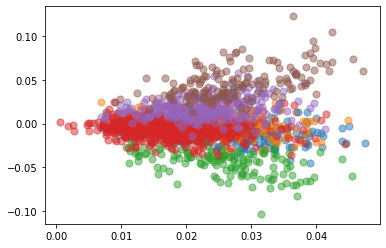

In [58]:
def get_plots(cluster_number):
    for i in range(cluster_number):
        plt.scatter(X[y_pred == i,0],X[y_pred == i,1], s=50, alpha=.5)
    plt.show()
    
get_plots(9)

In [59]:
# Added x,y,z coodinates to df
c_df = pd.DataFrame(X)
c_df = c_df.iloc[:, : 3]
c_df.columns = 'x','y','z'
c_df['clusters'] = y_pred
# Converted show_df genre column to list first to avoid nan values
genre = show_df['genre'].to_list()
c_df['genre'] = genre
# Converted show_df name column to list first to avoid nan values
name_show = show_df['name'].to_list()
c_df['tv_show'] = name_show

In [60]:
fig = px.scatter_3d(c_df,x='x', y='y', z='z', color='clusters', labels='genre', hover_name='tv_show', title='Predicted Clusters',
                   hover_data=c_df.columns, opacity=0.7, width=800, height=800, color_discrete_sequence=px.colors.qualitative.G10)

fig.show()

In [ ]:
''' Unused supervised learning regression model '''

In [62]:
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import TfidfVectorizer

X = show_df['summary']
y = show_df['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tf = text.TfidfVectorizer(max_features=5000, max_df=0.7)  

X_train = tf.fit_transform(X_train)
X_test = tf.transform(X_test)

In [63]:
from sklearn.linear_model import LogisticRegression

# Initialize classifier
log_reg_classifier = LogisticRegression(C=30.0, class_weight='balanced', solver='lbfgs', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
# Fit model
log_reg_classifier.fit(X_train, y_train)
# Predict
y_preds = log_reg_classifier.predict(X_test)

In [64]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_preds)
# Calculate precision
precision = precision_score(y_test, y_preds, average='micro')             
# Caluclate recall
recall = recall_score(y_test, y_preds, average='micro')
# Caluclate f1 score
f1 = f1_score(y_test, y_preds, average='micro')

print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1 score: ', f1)

accuracy:  0.7285318559556787
precision:  0.7285318559556787
recall:  0.7285318559556787
f1 score:  0.7285318559556787


In [65]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_preds)

array([[ 31,   0,   3,   0,   7,   2,   0,   2,   1],
       [  1,   1,   2,   0,   3,   0,   0,   0,   0],
       [  3,   0,  47,   1,  13,   0,   2,   3,   0],
       [  0,   0,   1,  12,   4,   0,   0,   0,   0],
       [ 10,   0,  13,   0, 104,   0,   0,   3,   1],
       [  4,   0,   1,   0,   1,  43,   0,   0,   0],
       [  0,   0,   3,   0,   1,   0,   5,   0,   0],
       [  3,   0,   2,   0,   2,   0,   0,  12,   1],
       [  1,   0,   0,   0,   4,   0,   0,   0,   8]], dtype=int64)

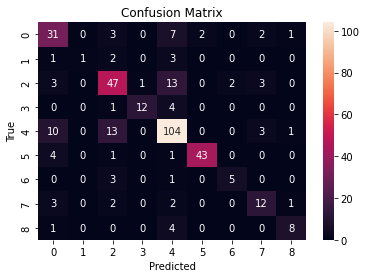

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted');ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);